## Problem Statement:

### What is the optimal bowling strategy in Chinnaswamy, Which type of bowlers to use & when (phase of play)?

- Venue analysis
- Historic trends
- Bowlers analysis

### Keywords Involved:
- Bowling Strategy
    - Bowlers analysis
    - By Phases of play - (PP/Middle/Death)
    - By Innings - (Bowl 1st/2nd)
- Venue Analysis
    - Performance in venues
    - Toss factor
    - Venue trends --- (runrates, wickets, ..)

In [3]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns',None)
pd.set_option('display.max_row',None)
pd.set_option('display.expand_frame_repr',False)
pd.set_option('display.max_colwidth',None)

import matplotlib.pyplot as plt

## Part 1: Bowler Statistics

In [5]:
deliveries = pd.read_csv('remaining_ballbyball.csv')
matches = pd.read_csv('remaining_match.csv')

In [6]:
deliveries = deliveries.rename(columns={'runs_of_bat':'batsman_runs'})

In [7]:
matches.head(2)

,id,season,city,date,match_type,player_of_match,venue,team1,team2,toss_winner,toss_decision,winner,result,result_margin,target_runs,target_overs,super_over,method,umpire1,umpire2
0,1359475,2023,Ahmedabad,2023-03-31,League,Rashid Khan,"Narendra Modi Stadium, Ahmedabad",Chennai Super Kings,Gujarat Titans,Gujarat Titans,field,Gujarat Titans,wickets,5.0,179.0,20.0,N,NaN,Nitin Menon,HAS Khalid
1,1359476,2023,Chandigarh,2023-04-01,League,Arshdeep Singh,"Punjab Cricket Association IS Bindra Stadium, Mohali, Chandigarh",Punjab Kings,Kolkata Knight Riders,Kolkata Knight Riders,field,Punjab Kings,runs,7.0,154.0,16.0,N,D/L,BNJ Oxenford,YC Barde


In [8]:
deliveries.head(2)

,match_id,inning,batting_team,bowling_team,over,ball,batsman,bowler,non_striker,batsman_runs,extra_runs,total_runs,extras_type,is_wicket,player_dismissed,dismissal_kind,fielder
0,1359475,1,Chennai Super Kings,Gujarat Titans,0,1,DP Conway,Mohammed Shami,RD Gaikwad,0,0,0,NaN,0,NaN,NaN,NaN
1,1359475,1,Chennai Super Kings,Gujarat Titans,0,2,DP Conway,Mohammed Shami,RD Gaikwad,0,1,1,legbyes,0,NaN,NaN,NaN


## Part 1.1 : Extracting required fields

### Filter only "Bowlers Wickets"

In [10]:
deliveries.dismissal_kind.unique()

array([nan, 'bowled', 'caught', 'lbw', 'stumped', 'retired hurt',
       'caught and bowled', 'run out', 'hit wicket', 'retired out',
       'obstructing the field'], dtype=object)

In [11]:
def is_wicket(player_dismissed, dismissal_kind):
    if type(player_dismissed) != str:
        return 0
    elif ~(type(player_dismissed) != str) & (dismissal_kind not in ['run out', 'retired hurt', 'obstructing the field']):
        return 1
    else:
        return 0

In [12]:
deliveries['isBowlerWk'] = deliveries.apply(lambda x: is_wicket(x['player_dismissed'], x['dismissal_kind']), axis = 1)

In [13]:
deliveries[deliveries.dismissal_kind == 'run out'].head(2)

,match_id,inning,batting_team,bowling_team,over,ball,batsman,bowler,non_striker,batsman_runs,extra_runs,total_runs,extras_type,is_wicket,player_dismissed,dismissal_kind,fielder,isBowlerWk
1944,1359482,2,Rajasthan Royals,Punjab Kings,19,3,SO Hetmyer,SM Curran,Dhruv Jurel,1,0,1,NaN,1,SO Hetmyer,run out,M Shahrukh Khan,0
2300,1359484,1,Sunrisers Hyderabad,Lucknow Super Giants,19,1,Abdul Samad,JD Unadkat,Umran Malik,1,0,1,NaN,1,Umran Malik,run out,DJ Hooda,0


In [14]:
deliveries[deliveries.dismissal_kind == 'lbw'].head(2)

,match_id,inning,batting_team,bowling_team,over,ball,batsman,bowler,non_striker,batsman_runs,extra_runs,total_runs,extras_type,is_wicket,player_dismissed,dismissal_kind,fielder,isBowlerWk
676,1359477,2,Delhi Capitals,Lucknow Super Giants,13,4,R Powell,Ravi Bishnoi,DA Warner,0,0,0,NaN,1,R Powell,lbw,NaN,1
1663,1359481,2,Gujarat Titans,Delhi Capitals,13,2,V Shankar,MR Marsh,B Sai Sudharsan,0,0,0,NaN,1,V Shankar,lbw,NaN,1


## Part 1.2 : Customized functions

### Custom fields: BPD, BPB, DOT%, Eco, Bowl Avg, Bowl SR

In [17]:
def balls_per_dismissal(balls, dismissals):
    if dismissals > 0:
        return balls/dismissals
    else:
        return balls/1
    
def balls_per_boundary(balls, boundaries):
    if boundaries > 0:
        return balls/boundaries
    else:
        return balls/1 

def get_dot_percentage(dots, balls):
    if balls > 0:
        return dots/balls
    else:
        return 0
    
def runs_per_ball(balls, runs_conceeded):
    if balls > 0:
        return runs_conceeded/balls
    else:
        return math.inf
    
def runs_per_dismissal(runs_conceeded, dismissals):
    if dismissals > 0:
        return runs_conceeded/dismissals
    else:
        return math.inf

def playerStatistics(df):
    
    df['isDot'] = df['batsman_runs'].apply(lambda x: 1 if x == 0 else 0)
    df['isOne'] = df['batsman_runs'].apply(lambda x: 1 if x == 1 else 0)
    df['isTwo'] = df['batsman_runs'].apply(lambda x: 1 if x == 2 else 0)
    df['isThree'] = df['batsman_runs'].apply(lambda x: 1 if x == 3 else 0)
    df['isFour'] = df['batsman_runs'].apply(lambda x: 1 if x == 4 else 0)
    df['isSix'] = df['batsman_runs'].apply(lambda x: 1 if x == 6 else 0)
    
    runs = pd.DataFrame(df.groupby(['bowler', 'match_id'])['total_runs'].sum().reset_index()).groupby(['bowler'])['total_runs'].sum().reset_index().rename(columns={'total_runs':'runs'})
    innings = pd.DataFrame(df.groupby(['bowler'])['match_id'].apply(lambda x: len(list(np.unique(x)))).reset_index()).rename(columns = {'match_id':'innings'})
    balls = pd.DataFrame(df.groupby(['bowler'])['match_id'].count()).reset_index().rename(columns = {'match_id':'balls'})
    dismissals = pd.DataFrame(df.groupby(['bowler'])['isBowlerWk'].sum()).reset_index().rename(columns = {'isBowlerWk':'dismissals'})
    
    dots = pd.DataFrame(df.groupby(['bowler'])['isDot'].sum()).reset_index().rename(columns = {'isDot':'dots'})
    ones = pd.DataFrame(df.groupby(['bowler'])['isOne'].sum()).reset_index().rename(columns = {'isOne':'ones'})
    twos = pd.DataFrame(df.groupby(['bowler'])['isTwo'].sum()).reset_index().rename(columns = {'isTwo':'twos'})
    threes = pd.DataFrame(df.groupby(['bowler'])['isThree'].sum()).reset_index().rename(columns = {'isThree':'threes'})
    fours = pd.DataFrame(df.groupby(['bowler'])['isFour'].sum()).reset_index().rename(columns = {'isFour':'fours'})
    sixes = pd.DataFrame(df.groupby(['bowler'])['isSix'].sum()).reset_index().rename(columns = {'isSix':'sixes'})
    
    df = pd.merge(innings, runs, on = 'bowler').merge(balls, on = 'bowler').merge(dismissals, on = 'bowler').merge(dots, on = 'bowler').merge(ones, on = 'bowler').merge(twos, on = 'bowler').merge(threes, on = 'bowler').merge(fours, on = 'bowler').merge(sixes, on = 'bowler')
    
    # Dot Percentage = Number of dots in total deliveries
    df['Dot%'] = df.apply(lambda x: get_dot_percentage(x['dots'], x['balls'])*100, axis = 1)
    
    # Average = Runs per wicket
    df['Avg'] = df.apply(lambda x: runs_per_dismissal(x['runs'], x['dismissals']), axis = 1)
    
    # StrikeRate = Balls per wicket
    df['SR'] = df.apply(lambda x: balls_per_dismissal(x['balls'], x['dismissals']), axis = 1)

    # Economy = runs per over
    df['Eco'] = df.apply(lambda x: runs_per_ball(x['balls'], x['runs'])*6, axis = 1)
    
    return df

In [18]:
df = playerStatistics(deliveries)

In [19]:
df.head()

,bowler,innings,runs,balls,dismissals,dots,ones,twos,threes,fours,sixes,Dot%,Avg,SR,Eco
0,A Badoni,3,25,13,0,2,7,1,0,1,2,15.384615,inf,13.000,11.538462
1,A Kamboj,3,115,68,2,27,20,5,0,10,6,39.705882,57.500000,34.000,10.147059
2,A Mishra,8,171,127,8,38,64,6,0,11,8,29.921260,21.375000,15.875,8.078740
3,A Nortje,16,668,391,17,151,113,30,0,58,39,38.618926,39.294118,23.000,10.250639
4,A Zampa,6,189,133,8,41,60,9,0,15,8,30.827068,23.625000,16.625,8.526316


In [20]:
df.sort_values('dismissals', ascending = False).head(20)

,bowler,innings,runs,balls,dismissals,dots,ones,twos,threes,fours,sixes,Dot%,Avg,SR,Eco
28,CV Varun,28,856,632,41,264,230,34,0,56,48,41.772152,20.878049,15.414634,8.126582
95,MM Sharma,25,790,513,40,155,218,41,0,61,38,30.214425,19.750000,12.825000,9.239766
181,YS Chahal,29,982,688,39,220,296,59,2,66,45,31.976744,25.179487,17.641026,8.563953
46,HV Patel,27,953,619,38,210,248,43,2,77,39,33.925687,25.078947,16.289474,9.237480
168,TU Deshpande,29,1015,678,38,302,188,49,0,91,48,44.542773,26.710526,17.842105,8.982301
142,Rashid Khan,29,929,669,37,223,286,52,0,62,46,33.333333,25.108108,18.081081,8.331839
19,Arshdeep Singh,28,1011,650,36,271,187,36,2,117,37,41.692308,28.083333,18.055556,9.332308
123,PP Chawla,27,811,586,35,196,259,34,2,55,40,33.447099,23.171429,16.742857,8.303754
103,Mohammed Siraj,28,902,679,34,345,181,27,1,89,36,50.810015,26.529412,19.970588,7.970545
83,M Pathirana,18,561,455,32,203,162,32,3,41,14,44.615385,17.531250,14.218750,7.397802


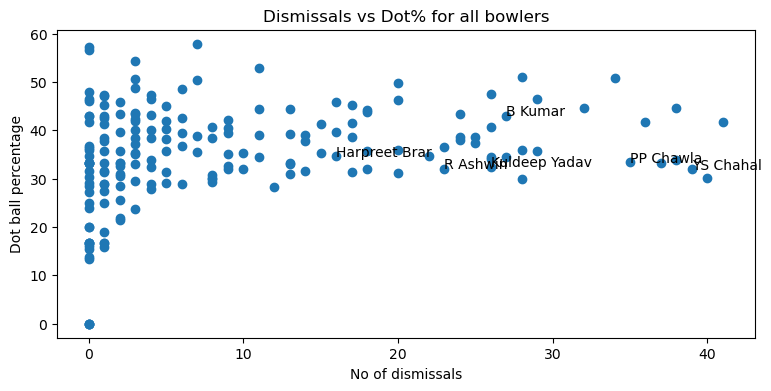

In [21]:
plt.figure(figsize = (9, 4))
plt.scatter(df['dismissals'], df['Dot%'])
plt.title('Dismissals vs Dot% for all bowlers')
plt.xlabel('No of dismissals')
plt.ylabel('Dot ball percentage')


annotations=list(df['bowler'])
selected_players = ['Kuldeep Yadav', 'R Ashwin', 'B Kumar', 'Marco Jansen', 
                    'YS Chahal', 'Harshal Patel', 'Cummins', 'Harpreet Brar', 
                    'Hardik Pandya', 'PP Chawla', 'Bumrah']
for i, label in enumerate(annotations):
    if label in selected_players:
        plt.annotate(label, (df['dismissals'][i], df['Dot%'][i]))
    
    
plt.show()

### 1.3 : Performance in different phases of play

In [23]:
def phase(over):
    # over number in our dataset starts from 0
    if over <= 5:
        return 'Powerplay'
    elif over <= 14:
        return 'Middle'
    else:
        return 'Death'

In [24]:
deliveries['phase'] = deliveries['over'].apply(lambda x: phase(x))

In [25]:
def phasesOfplay(df, current_phase):
    
    df = df[df.phase == current_phase]
    df.reset_index(inplace = True, drop = True)
    
    df['isDot'] = df['batsman_runs'].apply(lambda x: 1 if x == 0 else 0)
    df['isOne'] = df['batsman_runs'].apply(lambda x: 1 if x == 1 else 0)
    df['isTwo'] = df['batsman_runs'].apply(lambda x: 1 if x == 2 else 0)
    df['isThree'] = df['batsman_runs'].apply(lambda x: 1 if x == 3 else 0)
    df['isFour'] = df['batsman_runs'].apply(lambda x: 1 if x == 4 else 0)
    df['isSix'] = df['batsman_runs'].apply(lambda x: 1 if x == 6 else 0)
    
    runs = pd.DataFrame(df.groupby(['bowler', 'match_id'])['total_runs'].sum().reset_index()).groupby(['bowler'])['total_runs'].sum().reset_index().rename(columns={'total_runs':'runs'})
    innings = pd.DataFrame(df.groupby(['bowler'])['match_id'].apply(lambda x: len(list(np.unique(x)))).reset_index()).rename(columns = {'match_id':'innings'})
    balls = pd.DataFrame(df.groupby(['bowler'])['match_id'].count()).reset_index().rename(columns = {'match_id':'balls'})
    dismissals = pd.DataFrame(df.groupby(['bowler'])['isBowlerWk'].sum()).reset_index().rename(columns = {'isBowlerWk':'dismissals'})
    
    dots = pd.DataFrame(df.groupby(['bowler'])['isDot'].sum()).reset_index().rename(columns = {'isDot':'dots'})
    ones = pd.DataFrame(df.groupby(['bowler'])['isOne'].sum()).reset_index().rename(columns = {'isOne':'ones'})
    twos = pd.DataFrame(df.groupby(['bowler'])['isTwo'].sum()).reset_index().rename(columns = {'isTwo':'twos'})
    threes = pd.DataFrame(df.groupby(['bowler'])['isThree'].sum()).reset_index().rename(columns = {'isThree':'threes'})
    fours = pd.DataFrame(df.groupby(['bowler'])['isFour'].sum()).reset_index().rename(columns = {'isFour':'fours'})
    sixes = pd.DataFrame(df.groupby(['bowler'])['isSix'].sum()).reset_index().rename(columns = {'isSix':'sixes'})
    
    df = pd.merge(innings, runs, on = 'bowler').merge(balls, on = 'bowler').merge(dismissals, on = 'bowler').merge(dots, on = 'bowler').merge(ones, on = 'bowler').merge(twos, on = 'bowler').merge(threes, on = 'bowler').merge(fours, on = 'bowler').merge(sixes, on = 'bowler')
    
    # Dot Percentage = Number of dots in total deliveries
    df['Dot%'] = df.apply(lambda x: get_dot_percentage(x['dots'], x['balls'])*100, axis = 1)
    
    # Average = Runs per wicket
    df['Avg'] = df.apply(lambda x: runs_per_dismissal(x['runs'], x['dismissals']), axis = 1)
    
    # StrikeRate = Balls per wicket
    df['SR'] = df.apply(lambda x: balls_per_dismissal(x['balls'], x['dismissals']), axis = 1)

    # Economy = runs per over
    df['Eco'] = df.apply(lambda x: runs_per_ball(x['balls'], x['runs'])*6, axis = 1)
    
    return df

In [26]:
pp_df = phasesOfplay(deliveries, 'Powerplay')
mid_df = phasesOfplay(deliveries, 'Middle')
dth_df = phasesOfplay(deliveries, 'Death')

In [27]:
pp_df.sort_values('dismissals', ascending = False).head()

,bowler,innings,runs,balls,dismissals,dots,ones,twos,threes,fours,sixes,Dot%,Avg,SR,Eco
131,TA Boult,25,451,395,22,217,87,18,2,62,9,54.936709,20.500000,17.954545,6.850633
85,Mohammed Shami,17,335,275,17,163,40,17,3,41,11,59.272727,19.705882,16.176471,7.309091
19,B Kumar,30,563,417,17,218,87,20,3,72,17,52.278177,33.117647,24.529412,8.100719
86,Mohammed Siraj,28,466,366,15,209,72,12,1,55,17,57.103825,31.066667,24.400000,7.639344
29,DL Chahar,18,397,293,15,134,83,14,0,48,14,45.733788,26.466667,19.533333,8.129693


In [28]:
mid_df.sort_values('dismissals', ascending = False).head()

,bowler,innings,runs,balls,dismissals,dots,ones,twos,threes,fours,sixes,Dot%,Avg,SR,Eco
117,PP Chawla,27,659,476,30,151,220,31,1,40,33,31.722689,21.966667,15.866667,8.306723
128,RA Jadeja,30,762,615,28,189,313,42,0,39,32,30.731707,27.214286,21.964286,7.434146
26,CV Varun,28,497,383,28,159,143,23,0,31,27,41.514360,17.750000,13.678571,7.785901
173,YS Chahal,29,688,501,22,158,223,42,2,50,26,31.536926,31.272727,22.772727,8.239521
71,Kuldeep Yadav,25,586,460,21,147,233,24,0,24,32,31.956522,27.904762,21.904762,7.643478


In [29]:
dth_df.sort_values('dismissals', ascending = False).head()

,bowler,innings,runs,balls,dismissals,dots,ones,twos,threes,fours,sixes,Dot%,Avg,SR,Eco
34,HV Patel,25,462,278,27,98,96,26,1,36,21,35.251799,17.111111,10.296296,9.971223
67,M Pathirana,18,350,262,23,113,91,18,3,27,10,43.129771,15.217391,11.391304,8.015267
75,MM Sharma,20,386,237,22,72,94,25,0,23,23,30.379747,17.545455,10.772727,9.772152
130,TU Deshpande,27,464,265,21,106,74,22,0,38,25,40.000000,22.095238,12.619048,10.505660
126,T Natarajan,24,411,257,19,84,100,17,1,36,19,32.684825,21.631579,13.526316,9.595331


### 1.4 : Performance by Bat 1st/2nd

In [31]:
def ByInning(df, current_inning):
    
    df = df[df.inning == current_inning]
    df.reset_index(inplace = True, drop = True)
    
    df['isDot'] = df['batsman_runs'].apply(lambda x: 1 if x == 0 else 0)
    df['isOne'] = df['batsman_runs'].apply(lambda x: 1 if x == 1 else 0)
    df['isTwo'] = df['batsman_runs'].apply(lambda x: 1 if x == 2 else 0)
    df['isThree'] = df['batsman_runs'].apply(lambda x: 1 if x == 3 else 0)
    df['isFour'] = df['batsman_runs'].apply(lambda x: 1 if x == 4 else 0)
    df['isSix'] = df['batsman_runs'].apply(lambda x: 1 if x == 6 else 0)
    
    runs = pd.DataFrame(df.groupby(['bowler', 'match_id'])['total_runs'].sum().reset_index()).groupby(['bowler'])['total_runs'].sum().reset_index().rename(columns={'total_runs':'runs'})
    innings = pd.DataFrame(df.groupby(['bowler'])['match_id'].apply(lambda x: len(list(np.unique(x)))).reset_index()).rename(columns = {'match_id':'innings'})
    balls = pd.DataFrame(df.groupby(['bowler'])['match_id'].count()).reset_index().rename(columns = {'match_id':'balls'})
    dismissals = pd.DataFrame(df.groupby(['bowler'])['isBowlerWk'].sum()).reset_index().rename(columns = {'isBowlerWk':'dismissals'})
    
    dots = pd.DataFrame(df.groupby(['bowler'])['isDot'].sum()).reset_index().rename(columns = {'isDot':'dots'})
    ones = pd.DataFrame(df.groupby(['bowler'])['isOne'].sum()).reset_index().rename(columns = {'isOne':'ones'})
    twos = pd.DataFrame(df.groupby(['bowler'])['isTwo'].sum()).reset_index().rename(columns = {'isTwo':'twos'})
    threes = pd.DataFrame(df.groupby(['bowler'])['isThree'].sum()).reset_index().rename(columns = {'isThree':'threes'})
    fours = pd.DataFrame(df.groupby(['bowler'])['isFour'].sum()).reset_index().rename(columns = {'isFour':'fours'})
    sixes = pd.DataFrame(df.groupby(['bowler'])['isSix'].sum()).reset_index().rename(columns = {'isSix':'sixes'})
    
    df = pd.merge(innings, runs, on = 'bowler').merge(balls, on = 'bowler').merge(dismissals, on = 'bowler').merge(dots, on = 'bowler').merge(ones, on = 'bowler').merge(twos, on = 'bowler').merge(threes, on = 'bowler').merge(fours, on = 'bowler').merge(sixes, on = 'bowler')
    
    # Dot Percentage = Number of dots in total deliveries
    df['Dot%'] = df.apply(lambda x: get_dot_percentage(x['dots'], x['balls'])*100, axis = 1)
    
    # Average = Runs per wicket
    df['Avg'] = df.apply(lambda x: runs_per_dismissal(x['runs'], x['dismissals']), axis = 1)
    
    # StrikeRate = Balls per wicket
    df['SR'] = df.apply(lambda x: balls_per_dismissal(x['balls'], x['dismissals']), axis = 1)

    # Economy = runs per over
    df['Eco'] = df.apply(lambda x: runs_per_ball(x['balls'], x['runs'])*6, axis = 1)
    
    return df

In [32]:
ing1_df = ByInning(deliveries, 1)
ing2_df = ByInning(deliveries, 2)

In [33]:
ing1_df.sort_values('dismissals', ascending = False).head()

,bowler,innings,runs,balls,dismissals,dots,ones,twos,threes,fours,sixes,Dot%,Avg,SR,Eco
105,PP Chawla,17,510,368,26,125,162,21,2,30,28,33.967391,19.615385,14.153846,8.315217
117,Rashid Khan,15,451,364,22,128,160,29,0,28,19,35.164835,20.500000,16.545455,7.434066
39,HV Patel,15,556,352,21,117,143,22,2,44,24,33.238636,26.476190,16.761905,9.477273
137,TA Boult,16,519,389,20,179,110,28,2,54,16,46.015424,25.950000,19.450000,8.005141
123,SM Curran,15,533,320,19,113,106,27,1,47,26,35.312500,28.052632,16.842105,9.993750


In [34]:
# List of bowlers to filter
bowler_names = ['PP Chawla', 'Mohammed Shami', 'M Starc']

# Filter the DataFrame by multiple bowler names
filtered_ing1_df = ing1_df[ing1_df['bowler'].isin(bowler_names)]


In [35]:
filtered_ing1_df.head()

,bowler,innings,runs,balls,dismissals,dots,ones,twos,threes,fours,sixes,Dot%,Avg,SR,Eco
88,Mohammed Shami,9,311,226,17,119,43,16,2,34,12,52.654867,18.294118,13.294118,8.256637
105,PP Chawla,17,510,368,26,125,162,21,2,30,28,33.967391,19.615385,14.153846,8.315217


In [36]:
ing2_df.sort_values('dismissals', ascending = False).head()

,bowler,innings,runs,balls,dismissals,dots,ones,twos,threes,fours,sixes,Dot%,Avg,SR,Eco
84,MM Sharma,12,342,235,26,83,92,18,0,23,19,35.319149,13.153846,9.038462,8.731915
26,CV Varun,16,506,371,25,166,120,21,0,33,31,44.743935,20.240000,14.840000,8.183288
92,Mohammed Siraj,18,569,414,22,197,119,19,1,55,23,47.584541,25.863636,18.818182,8.246377
149,TU Deshpande,16,574,377,22,172,97,30,0,51,27,45.623342,26.090909,17.136364,9.135279
161,YS Chahal,12,318,264,22,90,115,28,1,23,7,34.090909,14.454545,12.000000,7.227273


In [37]:
#filter by bowler name
filtered_ing2_df = ing2_df[ing2_df['bowler'] == 'PP Chawla']


In [38]:
filtered_ing2_df.head()

,bowler,innings,runs,balls,dismissals,dots,ones,twos,threes,fours,sixes,Dot%,Avg,SR,Eco
108,PP Chawla,10,301,218,9,71,97,13,0,25,12,32.568807,33.444444,24.222222,8.284404


## Kuldeep Yadav's performance against all teams:

In [40]:
def isOut(player_dismissed):
    try:
        x = math.isnan(player_dismissed)
        return 0
    except:
        return 1

In [41]:
deliveries['isOut'] = deliveries['player_dismissed'].apply(lambda x: isOut(x)) 

In [42]:
deliveries.head(2)

,match_id,inning,batting_team,bowling_team,over,ball,batsman,bowler,non_striker,batsman_runs,extra_runs,total_runs,extras_type,is_wicket,player_dismissed,dismissal_kind,fielder,isBowlerWk,isDot,isOne,isTwo,isThree,isFour,isSix,phase,isOut
0,1359475,1,Chennai Super Kings,Gujarat Titans,0,1,DP Conway,Mohammed Shami,RD Gaikwad,0,0,0,NaN,0,NaN,NaN,NaN,0,1,0,0,0,0,0,Powerplay,0
1,1359475,1,Chennai Super Kings,Gujarat Titans,0,2,DP Conway,Mohammed Shami,RD Gaikwad,0,1,1,legbyes,0,NaN,NaN,NaN,0,1,0,0,0,0,0,Powerplay,0


In [43]:
selected_player = 'Kuldeep Yadav'

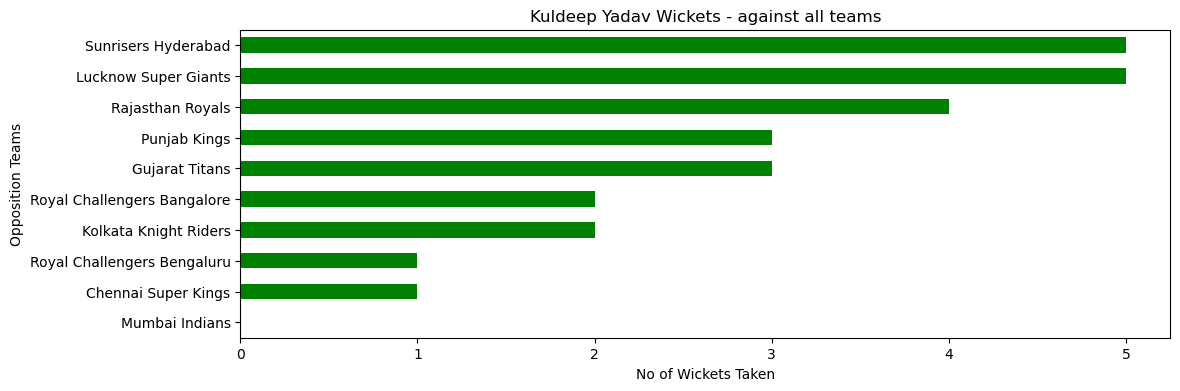

In [44]:
plt.figure(figsize = (12, 4))
deliveries[deliveries.bowler == selected_player].groupby(['batting_team'])['isOut'].sum().sort_values().plot(kind = 'barh', color = 'g')
plt.title('Kuldeep Yadav Wickets - against all teams')
plt.xlabel('No of Wickets Taken')
plt.ylabel('Opposition Teams')
plt.show()

## Part 2 : Venue Analysis

In [46]:
def wintoss_winmatch(toss_decision, team1, team2, winner):
    if toss_decision == 'field':
        if team2 == winner:
            return True
        else:
            return False
        
    else:
        if team1 == winner:
            return True
        else:
            return False


In [47]:
matches['wintoss_winmatch'] = matches.apply(lambda x: wintoss_winmatch(x['toss_decision'], x['team1'], x['team2'], x['winner']), axis = 1)

In [48]:
matches[['id', 'season', 'team1', 'team2', 'wintoss_winmatch']].head()

,id,season,team1,team2,wintoss_winmatch
0,1359475,2023,Chennai Super Kings,Gujarat Titans,True
1,1359476,2023,Punjab Kings,Kolkata Knight Riders,False
2,1359477,2023,Lucknow Super Giants,Delhi Capitals,False
3,1359478,2023,Rajasthan Royals,Sunrisers Hyderabad,False
4,1359479,2023,Mumbai Indians,Royal Challengers Bangalore,True


In [49]:
print('% of wintoss-winmatch =', 100*len(matches[matches.wintoss_winmatch == 1])/len(matches))

% of wintoss-winmatch = 44.827586206896555


In [50]:
pd.DataFrame(matches.groupby('season')['wintoss_winmatch'].sum().sort_values())

,wintoss_winmatch
season,
2024,31
2023,34


In [51]:
def isOut(player_dismissed):
    try:
        x = math.isnan(player_dismissed)
        return 0
    except:
        return 1

In [52]:
def venueAnalysis(mdf, df):
    
    runs = pd.DataFrame(df.groupby(['match_id', 'inning'])['total_runs'].sum().reset_index())
    runs['Id_Ing'] = runs.apply(lambda x: str(x['match_id']) + '-' + str(x['inning']), axis = 1)
    
    balls = pd.DataFrame(df.groupby(['match_id', 'inning'])['total_runs'].count().reset_index()).rename(columns = {'total_runs':'total_balls'})
    balls['Id_Ing'] = balls.apply(lambda x: str(x['match_id']) + '-' + str(x['inning']), axis = 1)
    
    df['isOut'] = df['player_dismissed'].apply(lambda x: isOut(x))
    outs = pd.DataFrame(df.groupby(['match_id', 'inning'])['isOut'].sum().reset_index()).rename(columns = {'isOut':'wickets'})
    outs['Id_Ing'] = outs.apply(lambda x: str(x['match_id']) + '-' + str(x['inning']), axis = 1)
    
    df = pd.merge(runs, balls[['Id_Ing', 'total_balls']], on = 'Id_Ing').merge(outs[['Id_Ing', 'wickets']], on = 'Id_Ing')
    
    mdf = mdf.rename(columns = {'id':'match_id'})
    df = pd.merge(df, mdf[['match_id', 'venue']], on = 'match_id')
    df = df[['match_id', 'venue', 'inning', 'total_runs', 'total_balls', 'wickets']]
    
    return df

In [53]:
ven_df = venueAnalysis(matches, deliveries)

In [54]:
ven_df.head()

,match_id,venue,inning,total_runs,total_balls,wickets
0,1359475,"Narendra Modi Stadium, Ahmedabad",1,178,121,7
1,1359475,"Narendra Modi Stadium, Ahmedabad",2,182,122,5
2,1359476,"Punjab Cricket Association IS Bindra Stadium, Mohali, Chandigarh",1,191,123,5
3,1359476,"Punjab Cricket Association IS Bindra Stadium, Mohali, Chandigarh",2,146,99,7
4,1359477,"Bharat Ratna Shri Atal Bihari Vajpayee Ekana Cricket Stadium, Lucknow",1,193,125,6


In [55]:
#fikter by venue name
filtered_df = ven_df[ven_df['venue'] == 'Arun Jaitley Stadium, Delhi']


In [56]:
filtered_df.head()


,match_id,venue,inning,total_runs,total_balls,wickets
12,1359481,"Arun Jaitley Stadium, Delhi",1,162,125,8
13,1359481,"Arun Jaitley Stadium, Delhi",2,163,115,4
30,1359490,"Arun Jaitley Stadium, Delhi",1,172,124,10
31,1359490,"Arun Jaitley Stadium, Delhi",2,173,122,4
54,1359502,"Arun Jaitley Stadium, Delhi",1,127,130,10


In [57]:
pd.DataFrame(ven_df.groupby('venue')['total_runs'].mean().sort_values(ascending = False)).rename(columns = {'total_runs':'Avg_Runs'}).reset_index().head(20)

,venue,Avg_Runs
0,"Dr. Y.S. Rajasekhara Reddy ACA-VDCA Cricket Stadium, Visakhapatnam",200.000000
1,"Arun Jaitley Stadium, Delhi",190.916667
2,"M Chinnaswamy Stadium, Bengaluru",190.071429
3,"Eden Gardens, Kolkata",189.500000
4,"Himachal Pradesh Cricket Association Stadium, Dharamsala",189.375000
5,"Wankhede Stadium, Mumbai",188.785714
6,"Punjab Cricket Association IS Bindra Stadium, Mohali, Chandigarh",185.600000
7,"Rajiv Gandhi International Stadium, Uppal, Hyderabad",182.423077
8,"Narendra Modi Stadium, Ahmedabad",176.823529
9,"Sawai Mansingh Stadium, Jaipur",171.050000


In [58]:
selected_venue = 'Dr. Y.S. Rajasekhara Reddy ACA-VDCA Cricket Stadium, Visakhapatnam'

In [59]:
ven_df[ven_df['venue'] == selected_venue].head()

,match_id,venue,inning,total_runs,total_balls,wickets
171,1422131,"Dr. Y.S. Rajasekhara Reddy ACA-VDCA Cricket Stadium, Visakhapatnam",1,191,127,5
172,1422131,"Dr. Y.S. Rajasekhara Reddy ACA-VDCA Cricket Stadium, Visakhapatnam",2,171,129,6
177,1422134,"Dr. Y.S. Rajasekhara Reddy ACA-VDCA Cricket Stadium, Visakhapatnam",1,272,134,7
178,1422134,"Dr. Y.S. Rajasekhara Reddy ACA-VDCA Cricket Stadium, Visakhapatnam",2,166,110,10


### Avg 1st & 2nd innings scores at MA Chidambaram Stadium, Chepauk, Chennai:

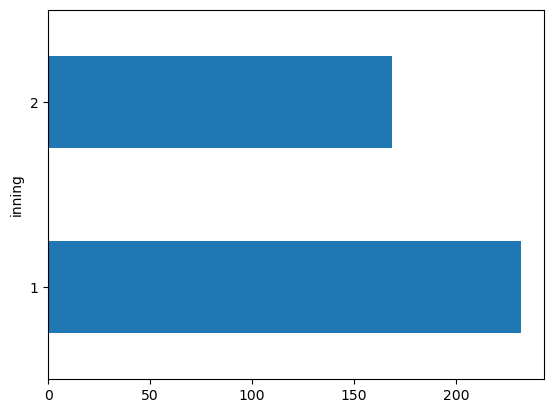

In [61]:
ven_df[ven_df['venue'] == selected_venue].groupby(['inning'])['total_runs'].mean()[:2].plot(kind ='barh')
plt.show()

In [62]:
matches.rename(columns = {'id':'match_id'}, inplace = True)

In [63]:
combined_data = deliveries.merge(matches[['match_id', 'venue']], on = 'match_id', how = 'left')

In [64]:
combined_data.head(1)

,match_id,inning,batting_team,bowling_team,over,ball,batsman,bowler,non_striker,batsman_runs,extra_runs,total_runs,extras_type,is_wicket,player_dismissed,dismissal_kind,fielder,isBowlerWk,isDot,isOne,isTwo,isThree,isFour,isSix,phase,isOut,venue
0,1359475,1,Chennai Super Kings,Gujarat Titans,0,1,DP Conway,Mohammed Shami,RD Gaikwad,0,0,0,NaN,0,NaN,NaN,NaN,0,1,0,0,0,0,0,Powerplay,0,"Narendra Modi Stadium, Ahmedabad"


In [65]:
def ByCustom(df, selected_venue):
       
    df = df[df.venue == selected_venue]
    df.reset_index(inplace = True, drop = True)
    
    df['isDot'] = df['batsman_runs'].apply(lambda x: 1 if x == 0 else 0)
    df['isOne'] = df['batsman_runs'].apply(lambda x: 1 if x == 1 else 0)
    df['isTwo'] = df['batsman_runs'].apply(lambda x: 1 if x == 2 else 0)
    df['isThree'] = df['batsman_runs'].apply(lambda x: 1 if x == 3 else 0)
    df['isFour'] = df['batsman_runs'].apply(lambda x: 1 if x == 4 else 0)
    df['isSix'] = df['batsman_runs'].apply(lambda x: 1 if x == 6 else 0)
    
    runs = pd.DataFrame(df.groupby(['bowler', 'match_id'])['total_runs'].sum().reset_index()).groupby(['bowler'])['total_runs'].sum().reset_index().rename(columns={'total_runs':'runs'})
    innings = pd.DataFrame(df.groupby(['bowler'])['match_id'].apply(lambda x: len(list(np.unique(x)))).reset_index()).rename(columns = {'match_id':'innings'})
    balls = pd.DataFrame(df.groupby(['bowler'])['match_id'].count()).reset_index().rename(columns = {'match_id':'balls'})
    dismissals = pd.DataFrame(df.groupby(['bowler'])['isBowlerWk'].sum()).reset_index().rename(columns = {'isBowlerWk':'dismissals'})
    
    dots = pd.DataFrame(df.groupby(['bowler'])['isDot'].sum()).reset_index().rename(columns = {'isDot':'dots'})
    ones = pd.DataFrame(df.groupby(['bowler'])['isOne'].sum()).reset_index().rename(columns = {'isOne':'ones'})
    twos = pd.DataFrame(df.groupby(['bowler'])['isTwo'].sum()).reset_index().rename(columns = {'isTwo':'twos'})
    threes = pd.DataFrame(df.groupby(['bowler'])['isThree'].sum()).reset_index().rename(columns = {'isThree':'threes'})
    fours = pd.DataFrame(df.groupby(['bowler'])['isFour'].sum()).reset_index().rename(columns = {'isFour':'fours'})
    sixes = pd.DataFrame(df.groupby(['bowler'])['isSix'].sum()).reset_index().rename(columns = {'isSix':'sixes'})
    
    df = pd.merge(innings, runs, on = 'bowler').merge(balls, on = 'bowler').merge(dismissals, on = 'bowler').merge(dots, on = 'bowler').merge(ones, on = 'bowler').merge(twos, on = 'bowler').merge(threes, on = 'bowler').merge(fours, on = 'bowler').merge(sixes, on = 'bowler')
    
    # Dot Percentage = Number of dots in total deliveries
    df['Dot%'] = df.apply(lambda x: get_dot_percentage(x['dots'], x['balls'])*100, axis = 1)
    
    # Average = Runs per wicket
    df['Avg'] = df.apply(lambda x: runs_per_dismissal(x['runs'], x['dismissals']), axis = 1)
    
    # StrikeRate = Balls per wicket
    df['SR'] = df.apply(lambda x: balls_per_dismissal(x['balls'], x['dismissals']), axis = 1)

    # Economy = runs per over
    df['Eco'] = df.apply(lambda x: runs_per_ball(x['balls'], x['runs'])*6, axis = 1)
    
    return df

In [66]:
df = ByCustom(combined_data, selected_venue)

In [134]:
df.sort_values('dismissals', ascending = False)

,bowler,innings,runs,balls,dismissals,dots,ones,twos,threes,fours,sixes,Dot%,Avg,SR,Eco
0,A Nortje,2,104,51,3,16,15,5,0,8,7,31.372549,34.666667,17.000000,12.235294
17,VG Arora,1,27,27,3,16,6,1,0,4,0,59.259259,9.000000,9.000000,6.000000
3,CV Varun,1,38,27,3,13,10,0,0,2,2,48.148148,12.666667,9.000000,8.444444
6,KK Ahmed,2,69,59,3,37,13,2,0,4,3,62.711864,23.000000,19.666667,7.016949
7,M Pathirana,1,32,26,3,12,9,1,0,3,1,46.153846,10.666667,8.666667,7.384615
10,Mukesh Kumar,1,21,19,3,9,6,1,0,3,0,47.368421,7.000000,6.333333,6.631579
5,I Sharma,2,67,38,2,14,12,1,0,8,3,36.842105,33.500000,19.000000,10.578947
8,MA Starc,1,29,18,2,10,3,1,0,2,2,55.555556,14.500000,9.000000,9.666667
11,Mustafizur Rahman,1,50,27,1,7,12,1,0,6,1,25.925926,50.000000,27.000000,11.111111
14,SP Narine,1,30,24,1,12,7,2,0,0,3,50.000000,30.000000,24.000000,7.500000


In [68]:
df[['Dot%', 'Avg', 'SR', 'Eco']].mean()

Dot%    38.106566
Avg           inf
SR      17.508772
Eco     10.304675
dtype: float64

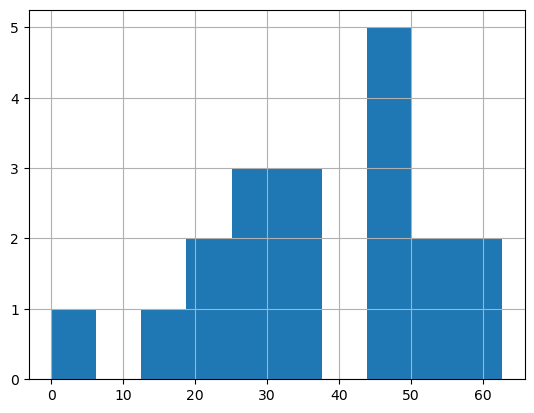

In [69]:
df['Dot%'].hist()
plt.show()

## Problem statement as Assignment:

In [71]:
df.sort_values('dismissals', ascending = False).head(20)

,bowler,innings,runs,balls,dismissals,dots,ones,twos,threes,fours,sixes,Dot%,Avg,SR,Eco
0,A Nortje,2,104,51,3,16,15,5,0,8,7,31.372549,34.666667,17.000000,12.235294
17,VG Arora,1,27,27,3,16,6,1,0,4,0,59.259259,9.000000,9.000000,6.000000
3,CV Varun,1,38,27,3,13,10,0,0,2,2,48.148148,12.666667,9.000000,8.444444
6,KK Ahmed,2,69,59,3,37,13,2,0,4,3,62.711864,23.000000,19.666667,7.016949
7,M Pathirana,1,32,26,3,12,9,1,0,3,1,46.153846,10.666667,8.666667,7.384615
10,Mukesh Kumar,1,21,19,3,9,6,1,0,3,0,47.368421,7.000000,6.333333,6.631579
5,I Sharma,2,67,38,2,14,12,1,0,8,3,36.842105,33.500000,19.000000,10.578947
8,MA Starc,1,29,18,2,10,3,1,0,2,2,55.555556,14.500000,9.000000,9.666667
11,Mustafizur Rahman,1,50,27,1,7,12,1,0,6,1,25.925926,50.000000,27.000000,11.111111
14,SP Narine,1,30,24,1,12,7,2,0,0,3,50.000000,30.000000,24.000000,7.500000
